# Bin2Cell ouputs
This notebook is adapted from the demo notebook from the authors: https://github.com/Teichlab/bin2cell?tab=readme-ov-file
It aims to help interpret the outputs, especially after running the EzPyzBin2cell app in sushi.

To start, install and activate the tmp_bin2cell_analysis environment and update the paths below to match your dataset

For a quick qc of your data, please have a look at the figures folder in the output dataset. it contains figures showing the results in a selected crop of the tissue

In [1]:
import bin2cell as b2c
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scanpy as sc
import squidpy as sq
import os

__init__.py (31): The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
utils.py (434): Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.


Due to the api porvided by bin2cell, it is easier to load the input data to see the intermediate results than to try to reconstruct them from the outputs. Thus please also provide the input dataset paths and parameters chosen to have the full analysis. This should still only take few minutes.

You can also skip this and go straight to the sesults by only updating the output path and jumping to the cell where cdata is defined.

For convenience, here is a parser which will extract all the relevant paths and parameters from the app input and output paths, so you can run the rest of the notebook without having to change anything. Just go to the output dataset and download the script to this workspace and use the parser function below on it

In [7]:
def parse_sushi_script(script_path):
    """
    Parse a Sushi EzPyzBin2CellApp script file to extract input/output paths and parameters.
    
    Parameters:
    -----------
    script_path : str
        Path to the Sushi script file (usually print_script.txt or similar)
    
    Returns:
    --------
    dict
        Dictionary containing all the extracted parameters needed for Bin2Cell analysis:
        - app_input_path: Base input directory path
        - microscopy_image_name: Name of the tissue image file
        - mpp: Microns per pixel value
        - buffer: Buffer size (default 150)
        - path: Path to binned outputs
        - source_image_path: Full path to source image
        - spaceranger_image_path: Path to spatial folder
        - app_output_path: Full path to output directory
    """
    import re
    import os
    
    with open(script_path, 'r') as f:
        content = f.read()
    
    # Extract parameters from the param dictionary
    mpp_match = re.search(r"param\['mpp'\]\s*=\s*['\"]([^'\"]+)['\"]", content)
    mpp = float(mpp_match.group(1)) if mpp_match else 0.5
    
    # Extract dataRoot (base projects path)
    data_root_match = re.search(r"param\['dataRoot'\]\s*=\s*['\"]([^'\"]+)['\"]", content)
    data_root = data_root_match.group(1) if data_root_match else "/srv/gstore/projects"
    
    # Extract resultDir for output path
    result_dir_match = re.search(r"param\['resultDir'\]\s*=\s*['\"]([^'\"]+)['\"]", content)
    result_dir = result_dir_match.group(1) if result_dir_match else ""
    
    # Extract sample name for constructing output path
    sample_match = re.search(r"param\['samples'\]\s*=\s*['\"]([^'\"]+)['\"]", content)
    sample_name = sample_match.group(1) if sample_match else ""
    
    # Extract input paths from the input dictionary
    binned_outputs_match = re.search(r"input\['BinnedOutputs2um'\]\s*=\s*['\"]([^'\"]+)['\"]", content)
    source_image_match = re.search(r"input\['SourceImage'\]\s*=\s*['\"]([^'\"]+)['\"]", content)
    
    if not binned_outputs_match or not source_image_match:
        raise ValueError("Could not extract required input paths from script file")
    
    # Construct paths
    binned_outputs_rel = binned_outputs_match.group(1)
    source_image_rel = source_image_match.group(1)
    
    # Extract the project directory from binned outputs path
    # e.g., "p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_002um/"
    project_match = re.match(r"([^/]+/[^/]+)/binned_outputs/", binned_outputs_rel)
    if not project_match:
        raise ValueError("Could not extract project path from BinnedOutputs2um")
    
    project_path = project_match.group(1)
    app_input_path = os.path.join(data_root, project_path)
    
    # Extract microscopy image name from source image path
    microscopy_image_name = os.path.basename(source_image_rel)
    
    # Construct other paths
    path = os.path.join(app_input_path, "binned_outputs/square_002um/")
    source_image_path = os.path.join(app_input_path, microscopy_image_name)
    spaceranger_image_path = os.path.join(path, "spatial/")
    
    # Construct output path
    app_output_path = os.path.join(data_root, result_dir, f"Bin2CellApp_{sample_name}")
    
    # Default buffer value (could be extracted from max_bin_distance if needed)
    buffer = 150
    
    return {
        'app_input_path': app_input_path,
        'microscopy_image_name': microscopy_image_name,
        'mpp': mpp,
        'buffer': buffer,
        'path': path,
        'source_image_path': source_image_path,
        'spaceranger_image_path': spaceranger_image_path,
        'app_output_path': app_output_path
    }

# Example usage:
# script_file = "/path/to/print_script.txt"
# params = parse_sushi_script(script_file)
# 
# # Extract individual parameters
# app_input_path = params['app_input_path']
# microscopy_image_name = params['microscopy_image_name']
# mpp = params['mpp']
# buffer = params['buffer']
# path = params['path']
# source_image_path = params['source_image_path']
# spaceranger_image_path = params['spaceranger_image_path']
# app_output_path = params['app_output_path']

In [11]:
# Automatically parse the script file and extract parameters
script_file = "/home/degottardiraphael/MasterThesis/Sushi outputs/print_script.txt"
params = parse_sushi_script(script_file)

# Extract individual parameters
app_input_path = params['app_input_path']
microscopy_image_name = params['microscopy_image_name']
mpp = params['mpp']
buffer = params['buffer']
path = params['path']
source_image_path = params['source_image_path']
spaceranger_image_path = params['spaceranger_image_path']
app_output_path = params['app_output_path']

print("Extracted parameters:")
print(f"app_input_path: {app_input_path}")
print(f"microscopy_image_name: {microscopy_image_name}")
print(f"mpp: {mpp}")
print(f"buffer: {buffer}")
print(f"app_output_path: {app_output_path}")

Extracted parameters:
app_input_path: /srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2
microscopy_image_name: Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2_tissue_image.btf
mpp: 0.5
buffer: 150
app_output_path: /srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2


In [12]:
manual_paths = False  # Set to True if you want to manually specify paths instead of parsing
if manual_paths:
    app_input_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2"
    microscopy_image_name = "Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2_tissue_image.btf"
    mpp = 0.5
    buffer = 150
    path = os.path.join(app_input_path, "binned_outputs/square_002um/")
    source_image_path = os.path.join(app_input_path, microscopy_image_name)
    spaceranger_image_path = os.path.join(path, "spatial/")

    app_output_path = "/srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2"

Loading the count matrix currently requires a bespoke loader function as 10X have moved the spot coordinates into a Parquet file, and started storing their tissue images into a separate `spatial` folder (with symlinks in the binned folders, which may break on transfer). The required syntax changes have been [offered to Scanpy](https://github.com/scverse/scanpy/pull/2992) so hopefully just using Scanpy's default loader will be sufficient soon.

Prior to the adjustment, the count total has a visible striped appearance. The effect is diminished after the correction.

In [ ]:
adata = b2c.read_visium(path, 
                        source_image_path = source_image_path, 
                        spaceranger_image_path = spaceranger_image_path
                       )
adata.var_names_make_unique()


anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


_construct.py (163): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
#this resolution is lower than the bin size
b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")
b2c.destripe(adata)


In [23]:
# Crop the data to a smaller region for visualization
# Select the coordinates of interest
row = 6300
col = 3300
expansion = 1000
crop = (row, col, row+expansion, col+expansion)


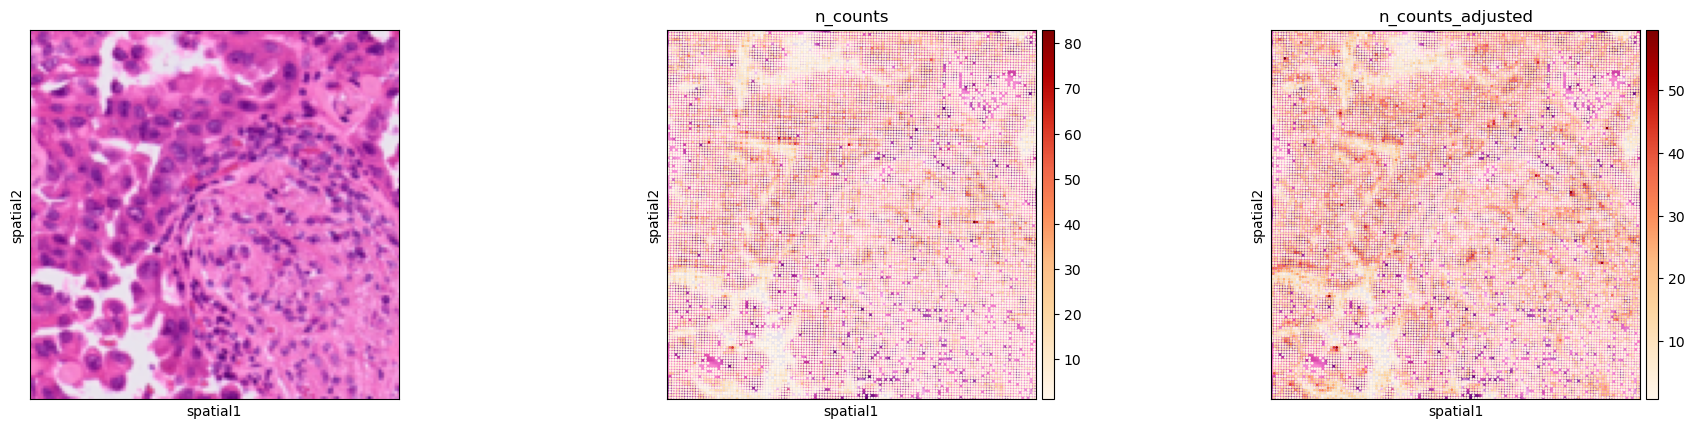

In [24]:
sq.pl.spatial_scatter(adata, color=[None, "n_counts", "n_counts_adjusted"], cmap="OrRd", crop_coord=crop)


In [ ]:
#We can adopt the nuclei labels from the stardist output
b2c.insert_labels(adata, 
                  labels_npz_path= os.path.join(app_output_path,"stardist/he.npz"), 
                  basis="spatial", 
                  spatial_key=f"spatial_cropped_{buffer}_buffer",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )

Let's visualise the nuclear H&E segmentation on our selected region. The nuclei are identified successfully.

In [25]:
imagename = list(adata.uns['spatial'].keys())[0]
crop_hires = tuple(int(c * adata.uns['spatial'][imagename]['scalefactors'][f'tissue_{mpp}_mpp_{buffer}_buffer_scalef']) for c in crop)
crop_hires

(3448, 1806, 3995, 2353)

Text(0.5, 1.0, 'Nuclei segemented by stardist (bin2cell)')

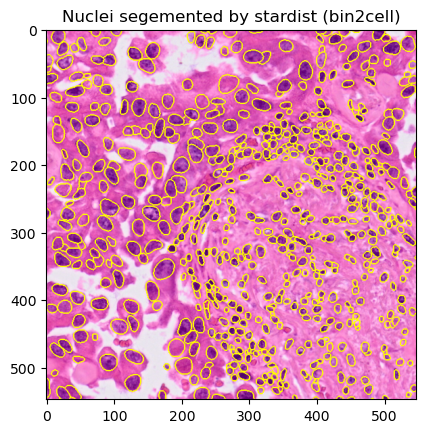

In [26]:
rendered = b2c.view_labels(image_path=f"{app_output_path}/stardist/he.tiff", 
                           labels_npz_path=f"{app_output_path}/stardist/he.npz", 
                           crop=crop_hires
                          )
plt.imshow(rendered)
plt.title("Nuclei segemented by stardist (bin2cell)")

In [18]:

b2c.expand_labels(adata, 
                  labels_key='labels_he', 
                  expanded_labels_key="labels_he_expanded"
                 )

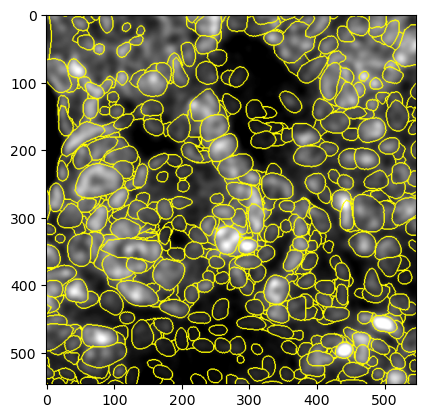

In [27]:
#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path=os.path.join(app_output_path,"stardist/gex.tiff"), 
                           labels_npz_path=os.path.join(app_output_path,"stardist/gex.npz"),
                           stardist_normalize=True,
                           crop = crop_hires #careful this is not the same coordinate system but close enough
                          )
plt.imshow(rendered)

The package comes with a utility function to visualise the segmentation on the input image (or a crop of it, as shown below). As we can see, the calls are faithfully captured in the bins.

The expanded labels capture more bins.

In [ ]:
#the labels obs are integers, 0 means unassigned
bdata = adata[adata.obs['labels_he_expanded']>0]
bdata #note that the remaining bins are discarded from now on (except the ones recovered by gex)

View of AnnData object with n_obs × n_vars = 2947329 × 17959
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'bin2cell'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

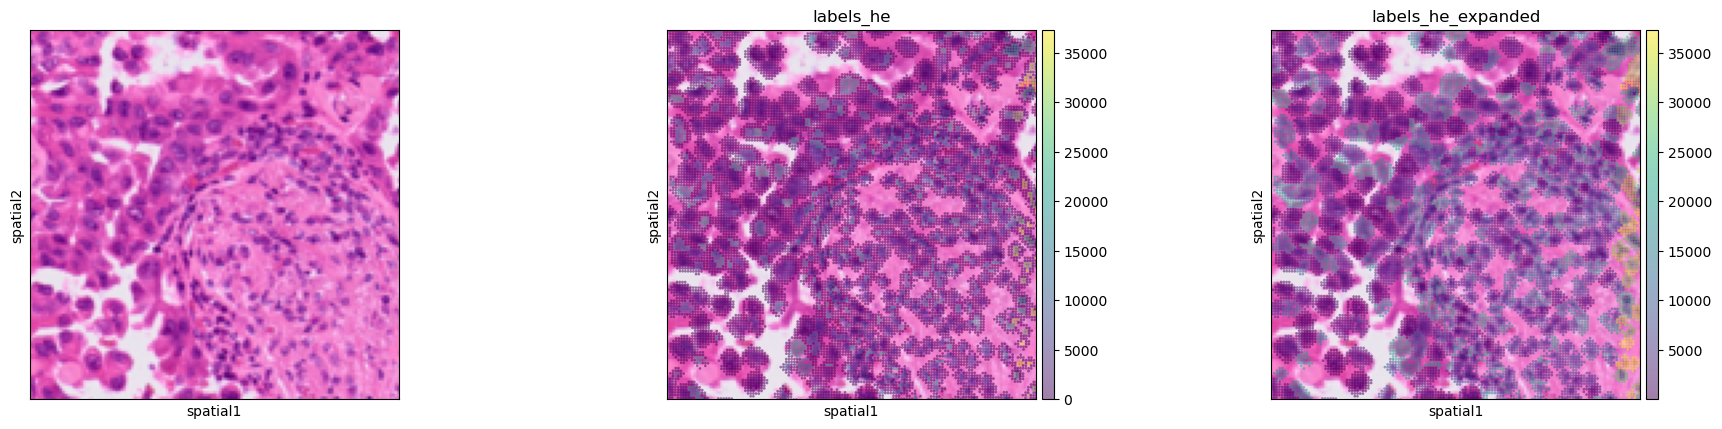

In [29]:
sq.pl.spatial_scatter(bdata, color=[None, "labels_he", "labels_he_expanded"], alpha=0.5, crop_coord=crop, legend_loc=None)

In [ ]:
# Filter the data within the crop
crop_mask = (
    (adata.obsm['spatial'][:, 0] >= crop[0]) & (adata.obsm['spatial'][:, 0] < crop[2]) &
    (adata.obsm['spatial'][:, 1] >= crop[1]) & (adata.obsm['spatial'][:, 1] < crop[3])
)

# Get the distinct labels_he_expanded within the crop
distinct_labels = adata.obs.loc[crop_mask, 'labels_he_expanded'].unique()
num_distinct_labels = len(distinct_labels)

num_distinct_labels #corresponds to the number of cells in the crop

634

# Expression (GEX)level segmentation

The H&E segmentation is not guaranteed to be perfect. There may be some regions that have expression data but lack a visible nuclei to seed a cell. Alternately, nuclei may take on unusual shapes and not be detected by the model. Performing segmentation on a representation of total expression per bin may be able to detect some of the missed cells. However, this kind of segmentation only performs well on sparse tissue, and struggles to differentiate individual cells in dense regions. As such, we use it as secondary means of object identification, preferring H&E where able.

The input image is going to be a representation of the total counts per bin, with a Gaussian filter with a sigma of 5 (measured in pixels) applied for a little smoothing.

The segmentation is performed via StarDist's fluorescence model, and identifies cells rather than nuclei, meaning subsequent label expasion is not necessary. Just like with the H&E model, lowering `prob_thresh` to make the calls less stringent is recommended. Increasing `nms_thresh` requires more of the putative objects to be overlapping for them to be merged into a single label, which may help a bit in denser regions.

The resulting calls are loaded like the H&E ones were, except the input image was based on array rather than spatial coordinates.

In [31]:
# needed for array_check to be added to adata
b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path="stardist/gex.tiff")

In [32]:
#again we dont run stardist here but use the labels from the App outputs
b2c.insert_labels(adata, 
                  labels_npz_path=os.path.join(app_output_path, "stardist/gex.npz"), 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )

We can visualise the cells identified in the GEX space segmentation in our previously defined region.

In [33]:
gdata = adata[adata.obs['labels_gex']>0]

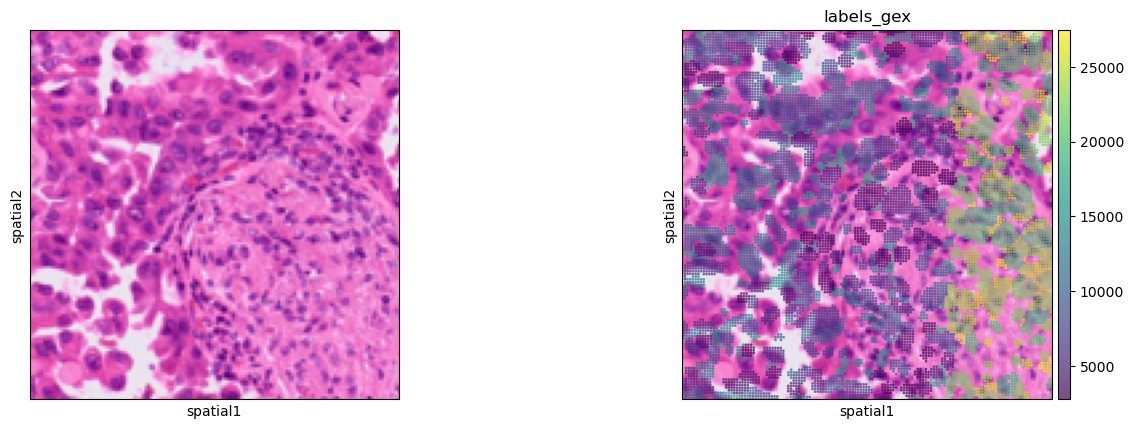

In [34]:
sq.pl.spatial_scatter(gdata, color=[None, "labels_gex"], alpha=0.7, crop_coord=crop, legend_loc=None)

The segmentation results can be viewed as well.

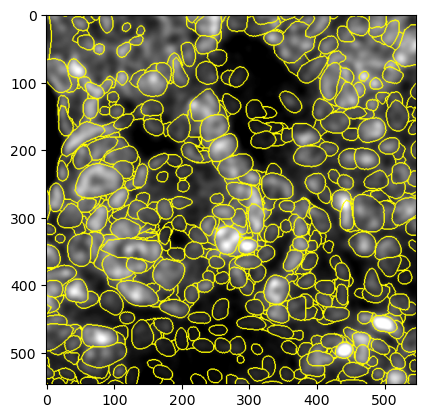

In [35]:
#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path=os.path.join(app_output_path,"stardist/gex.tiff"), 
                           labels_npz_path=os.path.join(app_output_path,"stardist/gex.npz"),
                           stardist_normalize=True,
                           crop = crop_hires #this is not fully accurate as bins have different coordinates than pixels but it is close enough
                          )
plt.imshow(rendered)

Armed with both the H&E and gene expression segmentation results, we can now fill in the gaps in the H&E with GEX calls. We only add GEX cells that do not overlap with any H&E labels.

In [36]:
b2c.salvage_secondary_labels(adata, 
                             primary_label="labels_he_expanded", 
                             secondary_label="labels_gex", 
                             labels_key="labels_joint"
                            )

Salvaged 20878 secondary labels


A few extra GEX-derived cells show up in our test region. Note the presence of `.obs["labels_joint_source"]` which specifies whether any given label came from the primary or secondary labelling.

In [37]:

jdata = adata[adata.obs['labels_joint']>0]


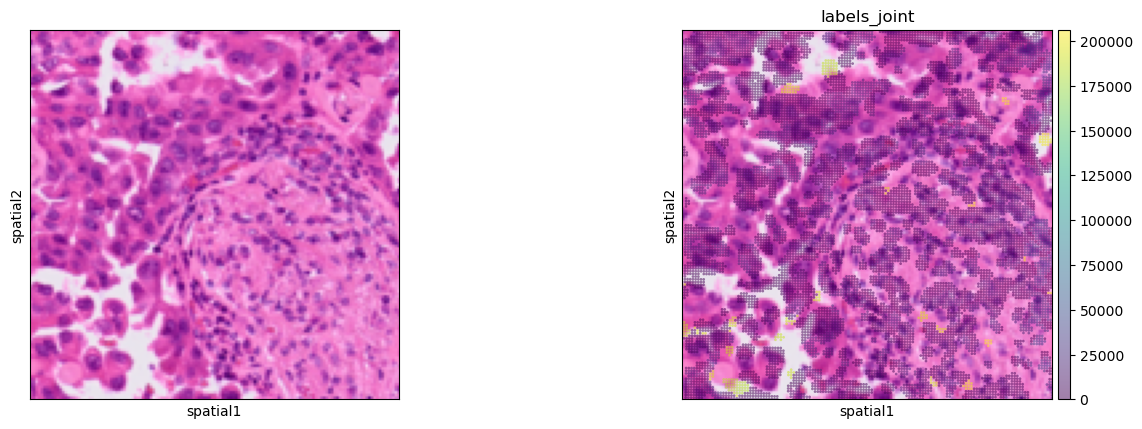

In [38]:
sq.pl.spatial_scatter(gdata, color=[None, "labels_joint"], alpha=0.5, crop_coord=crop, legend_loc=None)

At this point, the counts have been destriped and bins have been assigned to cells based on both H&E and GEX segmentation. Time to group the bins into cells!

In [39]:
#load the results computed by sushi
cdata = sc.read_h5ad(os.path.join(app_output_path, "cdata.h5ad"))

In [43]:
sc.pp.calculate_qc_metrics(cdata, inplace=True)
cdata

AnnData object with n_obs × n_vars = 193856 × 17959
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

The object features the sum of gene expression of the constituent bins, and means of the array and spatial coordinates to represent the cell centroids. `.obs["labels_joint_source"]` is taken as well, providing information on which segmentation any given cell stems from. Let's visualise our test fragment of the tissue, now in cell space!

0 39.0
removed 11187 outliers from a total of 193856 cells
0 352.3305036383016
removed 15255 outliers from a total of 193856 cells


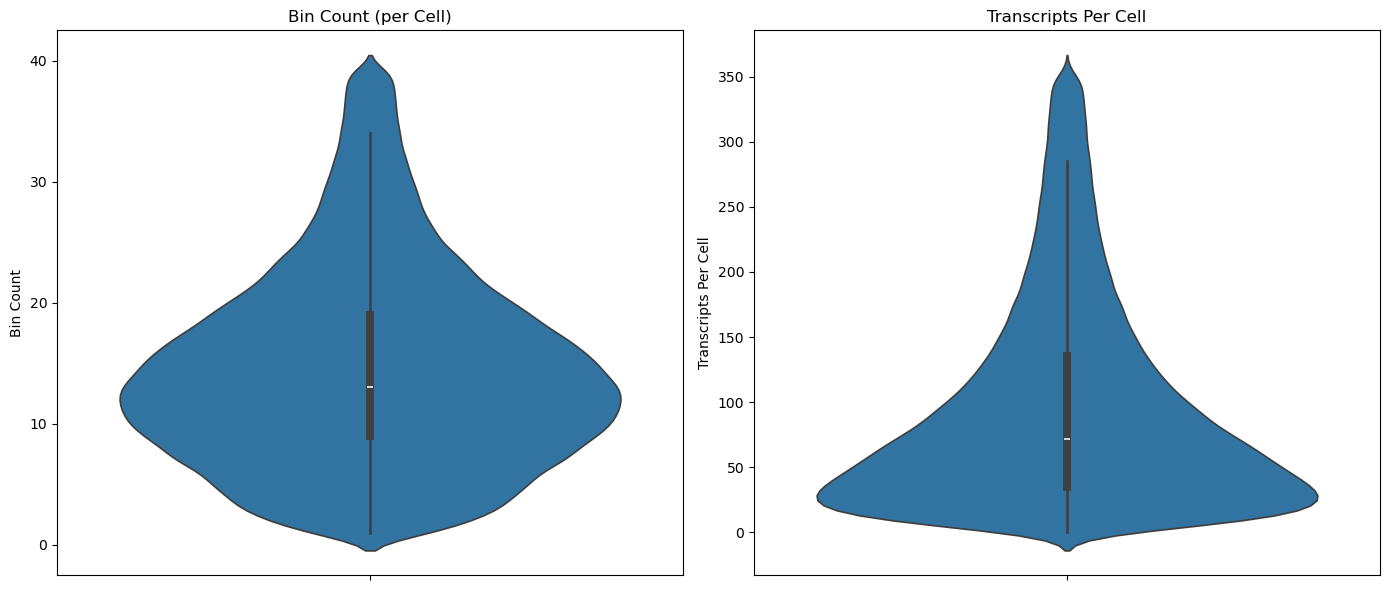

In [49]:
import numpy as np
# Filter out outliers in 'bin_count'
filtered_bin_count = cdata.obs['bin_count']
transcripts_per_cell = cdata.X.sum(axis=1).A1
# Function to remove outliers using IQR
def remove_outliers(arr):
    arr = np.asarray(arr)
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = q3 + 1.5 * iqr
    print(lower_bound, upper_bound)
    print(f"removed {np.sum(arr >= upper_bound)} outliers from a total of {len(arr)} cells")
    return arr[(arr >= lower_bound) & (arr <= upper_bound)]

# Remove outliers from the DataFrame
filtered_bin_count = remove_outliers(filtered_bin_count)
transcripts_per_cell = remove_outliers(transcripts_per_cell)

# Create violin plots for filtered_bin_count and transcripts_per_cell
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(y=filtered_bin_count, ax=axes[0])
axes[0].set_title('Bin Count (per Cell)')
axes[0].set_ylabel('Bin Count')

sns.violinplot(y=transcripts_per_cell, ax=axes[1])
axes[1].set_title('Transcripts Per Cell')
axes[1].set_ylabel('Transcripts Per Cell')

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate and print the mean and median bin count
mean_bin_count = np.mean(filtered_bin_count)
mean_cell_area = mean_bin_count * 4
median_bin_count = np.median(filtered_bin_count)

# Calculate and print the mean and median transcripts per cell
mean_transcripts_per_cell = np.mean(transcripts_per_cell)
median_transcripts_per_cell = np.median(transcripts_per_cell)

print(f"Mean bin count: {mean_bin_count:.2f}")
print(f"Mean cell area: {mean_cell_area:.2f} um^2")
print(f"Median bin count: {median_bin_count:.2f}")
print(f"Mean transcripts per cell: {mean_transcripts_per_cell:.2f}")
print(f"Median transcripts per cell: {median_transcripts_per_cell:.2f}")

Mean bin count: 14.61
Mean cell area: 58.43 um^2
Median bin count: 13.00
Mean transcripts per cell: 96.28
Median transcripts per cell: 71.39


In [ ]:
row = 6300
col = 3300
expansion = 1000
crop = (row, col, row+expansion, col+expansion)

In [31]:
cdata

AnnData object with n_obs × n_vars = 129580 × 19460
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

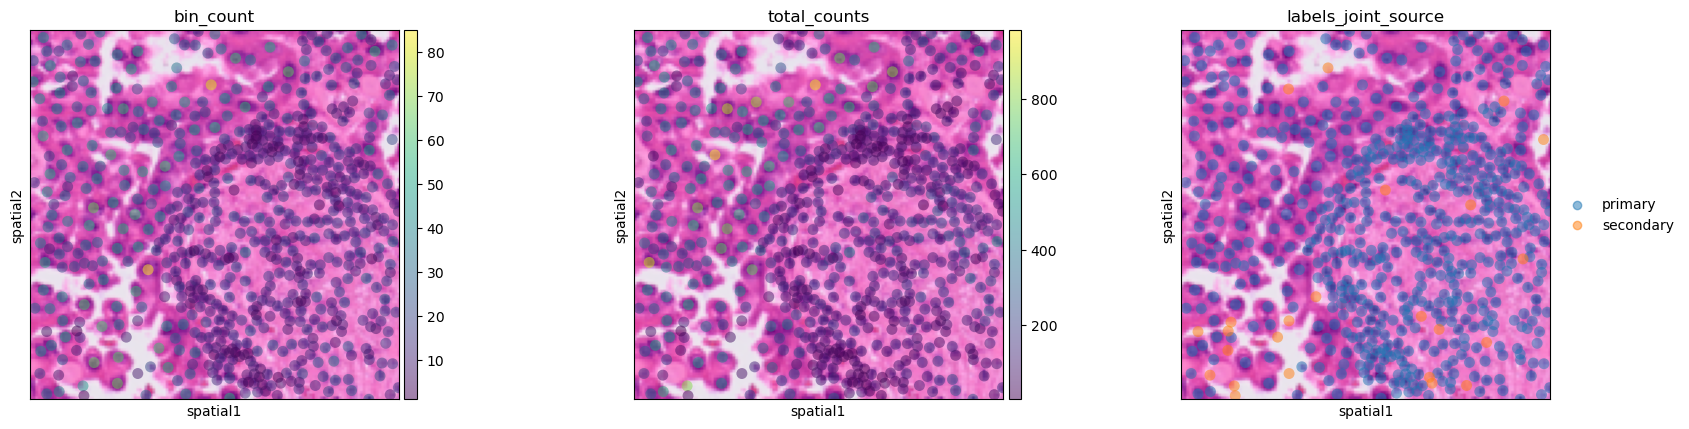

In [52]:

sq.pl.spatial_scatter(cdata, color=["bin_count", "total_counts", "labels_joint_source"], alpha=0.5, crop_coord=crop)


At this point the object is ready for further analysis. As destriping provides non-integer values, if integers are strictly necessary for a downstream application just round the count matrix.

## Plot UMAP, DEG and more
Consider running the EzPyzAnndataReport app on your outputs to obtain further interpretations of the results. 